In [1]:
import ROOT as r
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
import glob

Error in <TExMap::Add>: key 140259325695744 is not unique
TClassTable::Add:0: RuntimeWarning: class timespec already in TClassTable
Error in <TExMap::Add>: key 140259326261568 is not unique
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<int*,vector<int> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<string*,vector<string> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class reverse_iterator<__gnu_cxx::__normal_iterator<TString*,vector<TString> > > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<const char*,string> already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<char*,string> already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_iterator<int*,vector<int> > already in TClassTable
TClassTable::Add:0: RuntimeWarning: class __gnu_cxx::__normal_ite

In [2]:
#Custom C++ functions

r.gInterpreter.Declare("""
float SumAll(const ROOT::VecOps::RVec<double>& column) {
    float result;
    for (const auto& row : column) result += row;
    return result;
}
""")

r.gInterpreter.Declare("""
float getNhit(const ROOT::VecOps::RVec<double>& column, int low) {
    float result=0.0;
    for (const auto& row : column){ 
                       if(row > low) result += row;
                       }
    return result;
}
""")

True

In [ ]:

def get_integral_label(count):
    """
    ===== get_integral_label ======
    This function takes in a array of counts, usually from a histogram and returns a label display.
    Example:
        You input count = [10.000,90.000]
        it will return "Integral: 100k"

    param: 
        count, a 1-d arr that contains the counts for each bin in your graph
    return:
        a formated string for displaying the integral of count. 

    NOTE format only aberravates for < 1 Billion. 
    """
    integral = np.sum(count)
    if(integral < 1000):
        return f"Integral: {integral:.2f}"
    elif(integral < 1e6):
        return f"Integral: {integral/1e3:.2f}k"
    else:
        return f"Integral: {integral/1e6:.2f}M"
def get_fit_label(pop, pcov, fit_label=""):
    """
    ===== get_fit_label ======
    This function formats a string to display curve fitting information from SciPy for display on graphs or printouts.
    
    param: 
        pop, 1d arr of the curve fit values for each parameter in the curve fit function.
            if it is a linear relationship this should be [m,b] for y=mx+b
        
        pcov, 2d arr of the uncertainty of the curve fit values for each parameter in the curve fit function such that 
        the diagonals are the uncertainty of each parameter in the curve fit function. 
        
        fit_label, a 1d arr that has the desired char or string to display for each parameter in the curve fit function.
            if it is a linear relationship you can pass in ["slope","y-intercept"] and this will display as 
            "slope = m ± uncertainty(m), y-intercept = b ± uncertainty(b)
    return:
        The formatted string output given the input information.
            "fit_label[0] = pop[0] ± uncertainty(pop[0]), ..., fit_label[-1] = pop[-1] ± uncertainty(pop[-1])


    NOTE
    """
    string = ["" for _ in range(len(pop))]
    for i in range(len(pop)):
        string[i] = str(fit_label[i]) + ' = ' + str(round(pop[i],2)) + ' ± ' + str(round(np.sqrt(pcov[i][i]),2))
    label = ""
    for i in string:
        if i == string[len(string)-1]:
            label += str(i)
        else: label += str(i) + ', '
    return label
def get_curve_fit(curve_fit_function,bin_centers,count,param_guess):
    """
    ===== get_curve_fit ======
    This function uses scipy to curve fit data to a function. 
    
    param: 
        curve_fit_function, is the function you wish to curvefit to.
            if you are doing a linear fit then you would pass linear where def linear(x,m,b): return m*x+b
        
        bin_centers & count, are a 1d arr the pulled from using np.histogram on your data. 

        param_guess, is a 1d arr that has a guest of what the parameters should be where the
        length = number of parameters in your curve fit funciton minus the x parameter.
            If you are doing a quadratic curve fit where quad(x,a,b,c) then you should have a length 3 param_guess where [guess of a, guess of b, guess of c]
    return:
        x_fit, a arr of length 500 in the range of bin_centers min to its max value.
        y_fit, the values the curve fit function gives for the fitted parameters for all values in x_fit
        popt, the values SciPy curve fitted to for each parameter. 
        pcov, the convarence of the curve_fit. 

    NOTE
    """
    popt, pcov = curve_fit(curve_fit_function, bin_centers, count,p0=param_guess,)
    x_fit = np.linspace(min(bin_centers), max(bin_centers), 500)
    y_fit = curve_fit_function(x_fit, *popt)
    return [x_fit,y_fit,popt,pcov]

def plot_logscale(data,bins,label,title,xlabel,ylabel,bool_grid,bool_plot):
    """_summary_
    This function plots a histogram using matplotlib assuming a log scale for the x and y axis

    Args:
        data (1D_Arr): input data to be graphed
        bins (1D_Arr): the bins to be used for graphing the data, this should be logarithmic bins
        label (string): The label to be used on the graph. EG the data used or MC
        title (string): The title of the graph
        xlabel (string): x-axis label
        ylabel (string): y-axis label
        bool_grid (bool): bool that defines whether grid lines are drawn
        bool_plot (bool): bool sets whether graph should be drawn or not using plt.show()
    """    
    plt.hist(data, bins=bins,label=label)
    plt.title(title)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    if(bool_plot): plt.show()
    return
def plot_twoHist(data, x_range, num_bin, 
              title="", xlabel="",ylabel="Number of Events", plot=True,
              curve_fit_function = False,curve_fit_label="", param_guess=False,
              bool_log=True,bool_xlog=False, bool_grid=True, bool_error=False,
              data_label = "data",
              mc_data = False, mc_label = "MC",bool_scaleMC=True,
              bool_sort = False, bool_integral = True
              ):
    """_summary_
    Plots two histograms overlayed on each other, includes utilies such as curv fitting and display options. 

    Args:
        data (1d-arr): the data to be used for the data histogram
        x_range (tuple): The range for the graph to draw
        num_bin (int): The number of bins to make for the given range such that range/num_bin = bin width

        title (str, optional): he title of the graph. Defaults to "". T
        xlabel (str, optional): The x-axis label. Defaults to "". 
        ylabel (str, optional): The y-axis label. Defaults to "Number of Events". 
        plot (bool, optional): Defines wether the graph is plotted using plt.show(). Defaults to True. 

        curve_fit_function (function, optional): The function to curve fit to, using SciPy, For more information see get_curve_fit(). Defaults to False. 
        curve_fit_label (str, optional): For more information see get_curve_fit(). Defaults to "". 
        param_guess (1d-arr, optional): For more information see get_curve_fit(). Defaults to False. 

        bool_log (bool, optional): Checks if the y-axis should be log scale. Defaults to True. 
        bool_xlog (bool, optional): Checks if the x-axis should be log scale. Defaults to False. 
        bool_grid (bool, optional): Checks if gridlines should be drawn. Defaults to True. 
        bool_error (bool, optional): Checks if Data should be drawn as black error bars. Defaults to False.

        data_label (str, optional): Data label will be put onto the graph. Defaults to "data".

        mc_data (1d-arr): The MC Data to be graphed. Defaults to False. NOTE Not optional! 
        mc_label (str, optional): Label of the MC data, is put onto the graph. Defaults to "MC". 
        bool_scaleMC (bool, optional): Decides whether the MC should be scaled up/down to count(data). Defaults to True. 
        bool_sort (bool, optional): Forces sorting of MC and Data from highest to lowest bin on the graph. Defaults to False. NOTE Make sure to adjust X-axis!
        bool_integral (bool, optional): Will calculate the integral of data and display it on the graph. For more info see get_integral_label(). Defaults to True. 
    """    
    count, bin_edges = np.histogram(data, bins=np.arange(x_range[0],x_range[-1],num_bin))
    countMC, blah= np.histogram(mc_data,bin_edges)

    bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)]
    ErrCount1 = np.sqrt(count)
    ErrBin = (bin_centers[1]-bin_centers[0])/2  # horizontal error bars

    if(bool_scaleMC):
        # Scale MC to data
        data_in_range = ((data >= x_range[0]) & (data < x_range[-1]))
        mc_in_range = ((mc_data >= x_range[0]) & (mc_data < x_range[-1]))
        scale = np.sum(data_in_range) / np.sum(mc_in_range)
        
        print("Scaling MC by: ",scale)
        countMC = countMC * scale

    if(bool_sort):
        count = np.sort( np.array(count) )[::-1]
        countMC =np.sort( np.array(countMC) )[::-1]
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.title(title)
    
    if(bool_error): plt.errorbar(bin_centers, count, yerr=ErrCount1, xerr=ErrBin,
             ls='', marker='o', mfc='black', ms=4, mec='black',
             ecolor='black', label=data_label)
    else: plt.bar(bin_centers, count,color ='blue', width = ErrBin*2, label=data_label)
    
    plt.bar(bin_centers, countMC,color ='blue', width = ErrBin*2, label=mc_label)
    if(bool_integral): plt.plot([], [], ' ', label= get_integral_label(count))
    if(plot): plt.xlabel(xlabel, fontsize=15)
    if(plot): plt.ylabel(ylabel, fontsize=15)
    if(bool_log): plt.yscale('log')
    if(bool_xlog): plt.xscale('log')
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    if(plot): plt.legend(loc="upper right", borderaxespad=0,fancybox=True, shadow=True,)
    if(plot): plt.show()
def plot_3bar(x, xlim=[], 
              countData=[], CountMC=[], MC=[],
              data_label = "", mcCount_label = "", MC_label = "", 
              title="", xlabel="", ylabel = "Number of Events",
              bool_log = True, bool_errorBar = True, bool_grid = True, bool_scaleMC = True, bool_integral = True
              ):
    """_summary_
    Will plot 3 histograms over layed to each other TODO: Just make it a n-histogram overlay?
    NOTE Data = real data gathered from a detector, data arr is just the data inside of a array, either MC or Data.
    NOTE MC is not a count.
    Args:
        x (1d-arr): The bin edges used for the graph
        xlim (tuple, optional): Sets a limit in the range of xlim[0] < x-axis < xlim[-1] . Defaults to [].
        countData (list, optional): The counts for each bin of Data to be graphed. Defaults to [].
        CountMC (list, optional): The Counts for each bin of MC to be graphged. Defaults to [].
        MC (list, optional): The MC to be graphed, should different then CountMC. Defaults to []. NOTE This should be a normal data arr not a count!
        
        data_label (str, optional): The label of data to be put on the graph. Defaults to "".
        mcCount_label (str, optional): The label of CountMC to be put on the graph. Defaults to "".
        MC_label (str, optional): The label of MC to be put on the graph. Defaults to "".
        title (str, optional): The title of the graph. Defaults to "".
        xlabel (str, optional): The x-axis label. Defaults to "".
        ylabel (str, optional): The y-axis label. Defaults to "Number of Events".
        
        bool_log (bool, optional): Decides if y-axis should be log-scale. Defaults to True.
        bool_errorBar (bool, optional): decides if data should be graphed as black errorbars. Defaults to True.
        bool_grid (bool, optional): decides if gridlines should be graphed. Defaults to True.
        bool_scaleMC (bool, optional): decides if both countMC and MC should be scaled up/down to Data. Defaults to True.
        bool_integral (bool, optional): decides if the integral of data should be displayed, see get_integral_label() for more info. Defaults to True.
    """    
    MC_count, _ = np.histogram(MC,x)
    x_centers = 0.5 * (x[:-1] + x[1:]) 
    
    if(bool_errorBar): 
        xerr = 0.5 * np.diff(x)
        ErrCountData = np.sqrt(countData)
        plt.errorbar(x_centers, countData, yerr=ErrCountData, xerr=xerr,
                ls='', marker='o', mfc='black', ms=4, mec='black',
                ecolor='black', label=data_label)
    
    scaleMC = 1
    scaleCountMC = 1
    if(bool_scaleMC):   
        scaleMC = np.sum(countData) / np.sum(MC_count)
        
        print("Scaling MC by: ",scaleMC)
        
        scaleCountMC = np.sum(countData) / np.sum(CountMC)
        print("Scaling Count MC by: ", scaleCountMC)

    if(bool_integral): #TODO should be changed to the labels associated with each? 
        print("Data",get_integral_label(countData))
        print("MC Smear",get_integral_label(CountMC)) 
        print("MC Energy",get_integral_label(MC_count))

    if(len(CountMC) > 0): plt.bar(x_centers, CountMC * scaleCountMC,color ='blue', width =np.diff(x), label=mcCount_label)
    if(len(MC) > 0): plt.bar(x_centers, MC_count*scaleMC,color ='blue', width =np.diff(x), label=MC_label,edgecolor='red', facecolor='none')
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title)
    if(len(xlim)>0): plt.xlim([xlim[0],xlim[-1]])
    if(bool_log): plt.yscale('log')
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    plt.legend(borderaxespad=0,fancybox=True, shadow=True,)
    plt.show()

def plot_hist(data, x_range, num_bin, 
              title="", xlabel="",ylabel="Number of Events", plot=True,
              curve_fit_function = False,curve_fit_label="", param_guess=False,
              bool_log=True,bool_xlog=False, bool_grid=True, bool_error=False,
              data_label = "data",
              mc_data = False, mc_label = "MC", bool_scaleMC = True,
              bool_returnFit = False, style_color = 'blue', bool_sort = False,
              bool_integral = True
              ):
    """
    Plots a histogram of the data with optional curve fitting.
    Parameters:
    - data: The data to be plotted.
    - x_range: The range of x values for the histogram.
    - num_bin: The number of bins for the histogram.
    - title: The title of the plot.
    - xlabel: The label for the x-axis.
    - ylabel: The label for the y-axis.
    - plot: Whether to show the plot (default is True).
    - curve_fit_function: The function to fit the histogram data (default is False).
    - curve_fit_label: The label for the curve fit (default is an empty string).
    - param_guess: Initial guess for the curve fit parameters (default is False).
    - bool_log: Whether to use a logarithmic scale for the y-axis (default is True).
    - bool_xlog: Whether to use a logarithmic scale for the x-axis (default is False).
    """

    #Creating bins and error bars
    if(bool_xlog):
        plot_logscale(data=data,bins=np.logspace(start=np.log10(x_range[0]),stop=np.log10(x_range[-1]), num=num_bin),
                      title=title,label=data_label,xlabel=xlabel,ylabel=ylabel,
                      bool_grid=bool_grid,bool_plot=plot
                      )
        return 
    else: count, bin_edges = np.histogram(data, bins=np.arange(x_range[0],x_range[-1],num_bin))
    
    if(type(mc_data) != bool):
        plot_twoHist(data,x_range,num_bin,
                     title,xlabel,ylabel,plot,
                     curve_fit_function,curve_fit_label,param_guess,
                     bool_log,bool_xlog,bool_grid,bool_error,
                     data_label,mc_data,mc_label,bool_scaleMC, bool_sort = bool_sort, bool_integral= bool_integral
                     )
        return
    
    bin_centers = [(bin_edges[i] + bin_edges[i + 1]) / 2 for i in range(len(bin_edges) - 1)]
    ErrCount1 = np.sqrt(count)
    ErrBin = (bin_centers[1]-bin_centers[0])/2  # horizontal error bars
    
    #Manages curve fitting to the data
    if(curve_fit_function):
        x_fit, y_fit,popt,pcov = get_curve_fit(curve_fit_function,bin_centers,count,param_guess)
        


    # Plotting
    plt.figure(figsize=(12, 6))
    plt.title(title)
    if(curve_fit_function): plt.plot(x_fit, y_fit, 'r--', label=f'Fit: {curve_fit_label} a={popt[0]:.2f}, b={popt[1]:.2f}, c={popt[2]:.2f}')
    if(bool_error): plt.errorbar(bin_centers, count, yerr=ErrCount1, xerr=ErrBin,
             ls='', marker='o', mfc='black', ms=4, mec='black',
             ecolor='black', label=data_label)
    else: plt.bar(bin_centers, count,color =style_color, width = ErrBin*2, label=data_label)
    
    if(bool_integral): plt.plot([], [], ' ', label= get_integral_label(count))
    if(plot): plt.xlabel(xlabel, fontsize=15)
    if(plot): plt.ylabel(ylabel, fontsize=15)
    if(bool_log): plt.yscale('log')
    if(bool_xlog): plt.xscale('log')
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    #if(plot): plt.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0,fancybox=True, shadow=True,)
    if(plot): plt.legend(loc="upper right", borderaxespad=0,fancybox=True, shadow=True,)
    if(plot): plt.show()
    if(bool_returnFit): return popt

def plot_scatter(datax, datay, xlim=False, ylim=False, 
              title="", xlabel="",ylabel="", 
              plot=True,bool_log_y=False, bool_log_x=False, bool_grid=True,
              curve_fit_function = False,curve_fit_label="", param_guess=False, fit_label="", bool_returnFit = False
              ):
    """_summary_
    Plots a scatter plot using matplotlib with various utilites included such as curve fitting to functions through scipy
    Args:
        datax (_type_): The data to be used for the x-axis
        datay (_type_): The data to be used for the y-axis

        xlim (tuple, optional): Sets a limit the x-axis: xlim[0]<x-axis<xlim[-1]. Defaults to False.
        ylim (tuple, optional):  Sets a limit the y-axis: ylim[0]<y-axis<ylim[-1]. Defaults to False.

        title (str, optional): Title to be displayed on the graph. Defaults to "".
        xlabel (str, optional): x-axis label. Defaults to "".
        ylabel (str, optional): y-axis label. Defaults to "".

        plot (bool, optional): Displays the graph using matplotlib plt.show(). Defaults to True.
        bool_log_y (bool, optional): Sets the y-axis to log scale. Defaults to False.
        bool_log_x (bool, optional): Sets the x-axis to log scale. Defaults to False.
        bool_grid (bool, optional): Sets gridline on the graph. Defaults to True.

        curve_fit_function (bool, optional): For more information see get_curve_fit(). Defaults to False.
        curve_fit_label (str, optional): For more information see get_curve_fit(). Defaults to "".
        param_guess (bool, optional): For more information see get_curve_fit(). Defaults to False.
        fit_label (str, optional): For more information see get_curve_fit(). Defaults to "".
        bool_returnFit (bool, optional): Sets whether to return the curve fit parameters. Defaults to False.

    Returns:
        1d-arr: For more information see get_curve_fit()
    """    
    # Plotting
    plt.title(title)
    plt.plot(datax, datay,'.',markersize=5,label='Data points')
    
    if(curve_fit_function):
        if(param_guess): popt, pcov = curve_fit(curve_fit_function, datax, datay,p0=param_guess)
        else: popt, pcov = curve_fit(curve_fit_function, datax, datay)
        # Plot fit
        x_fit = np.linspace(min(datax), max(datax), 500)
        y_fit = curve_fit_function(x_fit, *popt)
        
        plt.plot(x_fit, y_fit, 'r--', label=get_fit_label(popt, pcov, fit_label))
    
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if(bool_log_y): plt.yscale('log')
    if(bool_log_x): plt.xscale('log')
    plt.legend()
    if(ylim): plt.ylim(ylim[0],ylim[-1])
    if(xlim): plt.xlim(xlim[0],xlim[-1])
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    if(plot): plt.show()
    if(bool_returnFit): return popt

def plot_hist2d(datax, datay, x_range=None, y_range=None, bin_width_x=1.0, bin_width_y=1.0,
                title="", xlabel="", ylabel="", data_label="data",
                plot=True, bool_grid=True,
                curve_fit_function=False, fit_label="", param_guess=False, bool_returnFit=False,
                bool_integral=True, bool_ylog = False, bool_xlog = False,
                bool_return_norm = False,
                scatter_x=[], scatter_y=[]
                ):
    """_summary_
    A histogram scatter plot with many included utils like curve_fit overlay, and scatter plot overlay. 
    Args:
        datax (1d-arr): The x axis data
        datay (1d-arr): The y axis data
        x_range (tuple, optional): The limit of the x_axis [min,max]. Defaults to Full range.
        y_range (tuple, optional): The limit of the y_axis [min,max]. Defaults to Full range.
        bin_width_x (float, optional): The width of the bins for x-axis. Defaults to 1.0.
        bin_width_y (float, optional): The width of the bins for y-axis. Defaults to 1.0.

        title (str, optional): The title to be used on the graph. Defaults to "".
        xlabel (str, optional): The label of the x-axis. Defaults to "".
        ylabel (str, optional): The label of the y-axis. Defaults to "".
        data_label (str, optional): The label to be put on the graph. Defaults to "data".

        plot (bool, optional): Sets whether to plot the graph using plt.show(). Defaults to True.
        bool_grid (bool, optional): Sets whether to plot the gridlines. Defaults to True.

        curve_fit_function (bool, optional): For more information see get_curve_fit(). Defaults to False.
        fit_label (str, optional): For more information see get_curve_fit(). Defaults to "".
        param_guess (bool, optional): For more information see get_curve_fit(). Defaults to False.
        bool_returnFit (bool, optional): Ses whether to return the curve_fit values. Defaults to False.

        bool_integral (bool, optional): For more information see get_integral_label(). Defaults to True.
        bool_ylog (bool, optional): Sets y-axis scale to log. Defaults to False.
        bool_xlog (bool, optional): Sets x-axis scale to log. Defaults to False.
        bool_return_norm (bool, optional): Sets whether to return hist2d information. Defaults to False.

        scatter_x (list, optional): X_scatter plot info. Defaults to [].
        scatter_y (list, optional): Y scatter plot info. Defaults to [].

    Returns:
        popt: For more information see get_curve_fit()
        [counts, x_edge, y_edge, img]: returns the information of the matplotlib hist2d. For more information see matplotlib hist2d()
    """    
    range_xy = [x_range, y_range] if x_range and y_range else None
    if(range_xy is None): range_xy=[[np.min(datax)),np.max(datax)],[np.min(datay)),np.max(datay)]] #Sets it to the full range of x and y data
    # Define bin edges using bin width
    bins_x = np.arange(x_range[0], x_range[1] + bin_width_x, bin_width_x)
    bins_y = np.arange(y_range[0], y_range[1] + bin_width_y, bin_width_y)
    if(bool_ylog): 
        num_bins_y = int((np.log10(y_range[1]) - np.log10(y_range[0])) / np.log10(1 + bin_width_y))
        bins_y = np.logspace(start=np.log10(y_range[0]), stop=np.log10(y_range[1]), num=num_bins_y)

    if(bool_xlog):
        num_bins_x = int((np.log10(x_range[1]) - np.log10(x_range[0])) / np.log10(1 + bin_width_x))
        bins_x = np.logspace(start=np.log10(x_range[0]), stop=np.log10(x_range[1]), num=num_bins_x)

    range_xy = [x_range, y_range]
    if (x_range is None and y_range is None):
        range_xy = None

    #Manages curve fitting to the data
    if(curve_fit_function):
        x_fit, y_fit,popt,pcov = get_curve_fit(curve_fit_function,datax,datay,param_guess)    
        plt.plot(x_fit, y_fit, 'r--', label=get_fit_label(popt, pcov, fit_label))
    
    counts, x_edge, y_edge, img = plt.hist2d(datax,datay,bins=[bins_x,bins_y] ,range=range_xy, norm=colors.LogNorm())

    if(bool_xlog): plt.xscale('log')
    if(bool_ylog): plt.yscale('log')
    plt.plot([], [], ' ', label=data_label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    if(bool_integral): plt.plot([], [], ' ', label= get_integral_label(np.histogram2d(datax, datay, bins=[bins_x,bins_y], range=range_xy)[0]))
    if(plot): plt.colorbar()
    if(len(scatter_x) > 3): plt.plot(scatter_x,scatter_y,'.k')
    if(plot): plt.legend(fancybox=True)
    if(bool_grid): plt.grid(True,which="both", linestyle=':')
    if(plot): plt.show() 
    if(bool_returnFit): return popt

    if(bool_return_norm) :
        return [counts, x_edge, y_edge, img]



#Makes a categorical bar chart
def plot_bar(pdgid_data, names, pdgids, title="",ylabel="Number of Events", plot=True):
    """_summary_
    Plots a categorical bar graph

    Args:
        pdgid_data (1d-arr, int): The data to be sorted into categories
        names (1d-arr,str): The name of each category 
        pdgids (1d-arr, int): The value associated with each name. NOTE should be in same order as @names!
        title (str, optional): Sets the graph title. Defaults to "".
        ylabel (str, optional): Sets the y-axis title. Defaults to "Number of Events".
        plot (bool, optional): Sets whether to plot the graph using matplotlib plt.show(). Defaults to True.
    """    
    #Make sure everything is a np array
    pdgid_data = np.array(pdgid_data)
    names = np.array(names)
    pdgids = np.array(pdgids)

    # Count matched PDG IDs
    counts = np.array([np.sum(pdgid_data == pid) for pid in pdgids])

    # Find unmatched PDG IDs
    matched_ids = set(pdgids)
    unique_ids_in_data = set(np.unique(pdgid_data))
    unmatched_ids = sorted(unique_ids_in_data - matched_ids)
    if unmatched_ids:
        print("⚠️ Warning: The following PDG IDs were not matched to any bin:")
        print("   →", unmatched_ids)

    # Removes unmatched PDG IDs from names and counts
    mask = counts > 0
    names = names[mask]
    counts = counts[mask]
    if len(names) == 0:
        print("⚠️ Warning: No PDG IDs matched the data. No plot will be generated.")
        return

    # Plotting
    x = np.arange(len(names))
    plt.figure(figsize=(8, 5))
    plt.bar(x, counts, tick_label=names, color='blue', edgecolor='black')

    plt.xlabel("Particle Type")
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.title(title)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    if(plot): plt.show()
def get_particle_count(data, title="mc_pdgID"):
    """_summary_
    Plotting categorical bar graph specifically for pdgID's
    NOTE For more info on how the plotting works see plot_bar()

    Args:
        data (1d-arr<int>): Input pdgID to sort
        title (str, optional): The title to be graphed. Defaults to "mc_pdgID".
    """    
    # Plot PDG ID
    particle_names = [
        'Photon', 'Electron', 'Muon', 'Tau',
        'Electron Neutrino', 'Muon Neutrino', 'Tau Neutrino',
        'Pion+', 'Pion-', 'Pion0',
        'Kaon+', 'Kaon-', 'Kaon0', 'Kaon0L', 'Kaon0S',
        'Neutron', 'Proton', 'Antiproton',
        'Deuteron', 'Triton', 'Alpha',
        'Lambda', 'Sigma+', 'Sigma0', 'Sigma-',
        'Xi0', 'Xi-', 'Omega-',
        'D+', 'D-', 'D0', 'D_s+', 'D_s-',
        'B+', 'B-', 'B0', 'B_s0', 'B_c+',
        'J/psi', 'Upsilon(1S)', 'Z boson', 'W+ boson', 'W- boson', 'Higgs boson', 'Gluon'
    ]

    particle_pdgs = [
        22,  # Photon
        11,  # Electron
        13,  # Muon
        15,  # Tau
        12,  # Electron neutrino
        14,  # Muon neutrino
        16,  # Tau neutrino
        211,  # Pi+
    -211,  # Pi-
        111,  # Pi0
        321,  # K+
    -321,  # K-
        311,  # K0
        130,  # K0L
        310,  # K0S
    2112,  # Neutron
    2212,  # Proton
    -2212,  # Antiproton
    1000010020, # Deuteron
    1000010030, # Triton
    1000020040, # Alpha particle (Helium-4 nucleus)
    3122,  # Lambda
    3222,  # Sigma+
    3212,  # Sigma0
    3112,  # Sigma-
    3322,  # Xi0
    3312,  # Xi-
    3334,  # Omega-
    411,   # D+
    -411,   # D-
    421,   # D0
    431,   # D_s+
    -431,   # D_s-
    521,   # B+
    -521,   # B-
    511,   # B0
    531,   # B_s0
    541,   # B_c+
    443,   # J/psi
    553,   # Upsilon(1S)
        23,  # Z boson
        24,  # W+ boson
        -24,  # W- boson
        25,  # Higgs boson
        21   # Gluon
    ]

    plot_bar((data), particle_names, particle_pdgs,title)

#Flattens two-dimenisional data
def flat(data, isMax=False,isLen=False,isSum = True):
    """_summary_
    Flattens a 2-d arr through various methods. 
    NOTE defaults to series flattening of the array such that [[1,2],[3,4]] = [1,2,3,4]
    Args:
        data (2-d arr<float>): Data to flatten
        isMax (bool, optional): Flattens by getting the max value in each column. Defaults to False.
            [[1,2],[3,4]] = [2,4]
        isLen (bool, optional): Flattens by return the length of each column . Defaults to False.
            [[1,2],[3,4]] = [2,2]
        isSum (bool, optional): Flattens by summing each column. Defaults to True.
            [[1,2],[3,4]] = [3,7]

    Returns:
        1d-arr: The flattened array
    """    
    if(isMax): return np.array([np.max(i) if len(i)>0 else float('nan') for i in data])
    if(isLen): return np.array([len(i) for i in data])
    if(isSum): return np.array([np.sum(np.abs(i)) for i in data] )
    return np.array([i for sublist in data for i in sublist])


def get_mask(data, range):
    """_summary_
    Makes a boolean mask of the inputed data for the given range
    Args:
        data (1d-arr<float>): The inputed data for which the boolean mask will be made from.
        range (tuple): The range to which the data should exist in such that range[0] < data < range[-1]

    Returns:
        1d-arr<bool>: for [0,1,2,3,4,5] with range[2,4] returns [False,False,True,True,False,False]
    """
    return np.array( (data >= range[0]) & (data < range[-1]) )

def get_RDF(pattern = "*.root", path_name = "/data/ahicks3/projects/eos/michelElectron/MC/", ttree_name = "output" ):
    """_summary_
    Constructs a RDataFrame from a given file or files.
    Args:
        pattern (str, optional): The file pattern to search for in the given path directory passed in @path_name. Defaults to "*.root".
        path_name (str, optional): The path of the directory the file exists in. Defaults to "/data/ahicks3/projects/eos/michelElectron/MC/".
        ttree_name (str, optional): The ttree to pull. Defaults to "output".

    Returns:
        RDataFrame: constructed RDataFrame
    """    
    try:
        file_list = glob.glob(path_name+pattern)
    except:
        print("Glob Failed")
    try:
        rdf_x = r.RDataFrame(ttree_name, file_list)
        return rdf_x
    except:
        print("ERROR: Creation of rdf failed")
        return 0

In [46]:
# Create RDataFrame from the events tree of the input file.
mc = "MC 417 Flat"
#mc_dir = "MC_vesselFILL_Run417_Total300_DIR/"
mc_dir = "MC_flatE_outerTank_Run417_Total600K_DIR/"
mc_rdf = get_RDF(path_name="/data/ahicks3/projects/eos/simulations/michelElectron/MC/"+mc_dir)

#All filters and variable definition
#Keeps only events with n number of PMT that triggered on > x amount of charge
mc_rdf = mc_rdf.Define("newdigitCharge","digitCharge * 0.75")
mc_rdf = mc_rdf.Define("nTriggered", "ROOT::VecOps::Sum(newdigitCharge > 15)") # x amount of charge
mc_rdf = mc_rdf.Filter("nTriggered >=5") #n number of PMT

mc_rdf = mc_rdf.Define("new_NHIT", "ROOT::VecOps::Sum( (newdigitCharge > 1.5) && (newdigitCharge < 1600) )")
mc_rdf = mc_rdf.Define("totalCharge","ROOT::VecOps::Sum(newdigitCharge[ newdigitCharge > 1.5 ])") #Calculates total charge for greater then 0 events
mc_rdf = mc_rdf.Define("totalPEcount","ROOT::VecOps::Sum(digitReconNPEs)")

In [47]:
mc_columns = mc_rdf.AsNumpy(columns=["digitNhits","newdigitCharge","totalCharge","mcke","digitPMTID","mcx","mcy","mcz","totalPEcount"])

In [48]:
#Extract mc_branches
mc_nhits = mc_columns["digitNhits"]
#mc_pdgID = mc_columns["mcpdg"]
flat_mc_charge = mc_columns["totalCharge"]
mc_charge = mc_columns["newdigitCharge"]
#mc_time = mc_rdf.AsNumpy(columns=["timeSinceLastTrigger_us"])["timeSinceLastTrigger_us"]
mc_energy = mc_columns["mcke"]
mc_pmtID = mc_columns["digitPMTID"]
mc_x = mc_columns["mcx"]
mc_y = mc_columns["mcy"]
mc_z = mc_columns["mcz"]
mc_peCount = mc_columns["totalPEcount"]

# Plot PDG ID
#get_particle_count(abs(mc_pdgID))
#print(len(mc_nhits))

In [52]:
bool_mcCharge = get_mask(flat_mc_charge,[0,2500])
bool_mc = bool_mcCharge

In [8]:
#plot_hist2d(datax= np.array(np.sqrt(mc_x**2+mc_y**2)), num_bin_x=100, xlabel="Radius [mm]",
#            datay= mc_z, num_bin_y=100, ylabel = "Height [mm]",
#            data_label=mc, title="MC : mcZ vs mcRadius"
#)

In [34]:
#Pulls the file
run417_rdf = r.RDataFrame("output", "/data/eos/run417/data-417.root")
run = "Run 417"

#Sets defines variables & Sets filtering
run417_rdf= run417_rdf.Define("nTriggered", "ROOT::VecOps::Sum( (digitCharge > 1.5) && (digitCharge < 1600) )")
run417_rdf= run417_rdf.Define("totalCharge", "ROOT::VecOps::Sum( digitCharge[ digitCharge > 1.5 ] )")
run417_rdf = run417_rdf.Define("totalPEcount","ROOT::VecOps::Sum(digitReconNPEs)")

In [35]:
#Converts rdf to a mapped numpy array
run417_columns = run417_rdf.AsNumpy(["totalCharge","timeSinceLastTrigger_us","nTriggered","digitPMTID","digitCharge","totalPEcount"])

In [36]:
# Extract mc_branches
run417_charge = run417_columns["totalCharge"]
run417_time = run417_columns["timeSinceLastTrigger_us"]
run417_nhits = run417_columns["nTriggered"]
run417_channel = run417_columns["digitPMTID"]
run417_individualcharge = run417_columns["digitCharge"]
run417_peCount = run417_columns["totalPEcount"]

In [7]:
#Filter Data based on time and charge
bool_time_run417 = get_mask(run417_time, [1, 3])
bool_charge_run417 = get_mask(run417_charge,[0,2500])
bool_run417 = bool_time_run417 & bool_charge_run417

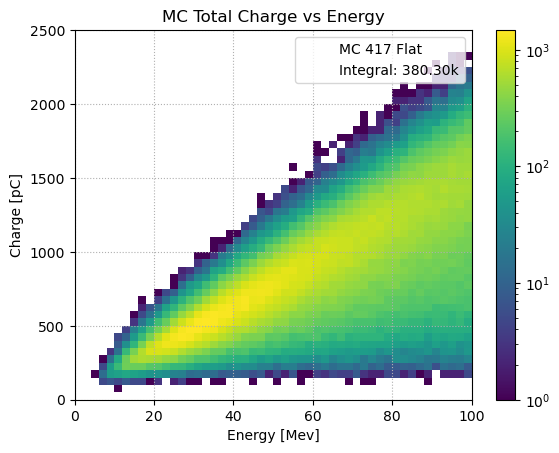

In [12]:
bin_width_x = 2 #Energy Width
bin_width_y = 50 #Charge Width

counts, energy_edge, charge_edge, img = plot_hist2d(datax= mc_energy[bool_mc],x_range=[0,100], bin_width_x=bin_width_x, xlabel="Energy [Mev]",
                  datay= flat_mc_charge[bool_mc],y_range=[0,2500],bin_width_y=bin_width_y, ylabel="Charge [pC]",
                  title="MC Total Charge vs Energy", data_label=mc, bool_return_norm=True
                  )
charge_edge = np.array(charge_edge)


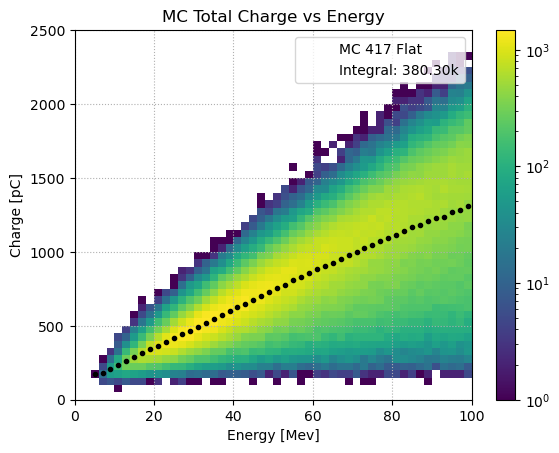

[array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([  0,   2,   4,   6,   8,  10,  12,  14,  16,  18,  20,  22,  24,
         26,  28,  30,  32,  34,  36,  38,  40,  42,  44,  46,  48,  50,
         52,  54,  56,  58,  60,  62,  64,  66,  68,  70,  72,  74,  76,
         78,  80,  82,  84,  86,  88,  90,  92,  94,  96,  98, 100]),
 array([   0,   50,  100,  150,  200,  250,  300,  350,  400,  450,  500,
         550,  600,  650,  700,  750,  800,  850,  900,  950, 1000, 1050,
        1100, 1150, 1200, 1250, 1300, 1350, 1400, 1450, 1500, 1550, 1600,
        1650, 1700, 1750, 1800, 1850, 1900, 1950, 2000, 2050, 2100, 2150,
        2200, 2250, 2300, 2350, 2400, 2450, 2500]),

In [13]:
chargeAvg = []

def linear(x,m,b):
    return m*x+b

for i in range(0,len(energy_edge)-1):
    charge_counts_i = ( counts[i,:] ).flatten()
    
    N = np.sum(charge_counts_i)
    if N == 0:
        chargeAvg_i = 0
    else:
        weight_i =np.array( charge_counts_i / (N * np.diff(charge_edge)) )
        charge_centers = 0.5 * (charge_edge[:-1] + charge_edge[1:]) 
        chargeAvg_i = np.average(charge_centers, weights=charge_counts_i)    

    chargeAvg.append(chargeAvg_i)

chargeAvg = np.array(chargeAvg)

mask_zero =chargeAvg!=0

plot_hist2d(datax= mc_energy[bool_mc],x_range=[0,100], bin_width_x=bin_width_x, xlabel="Energy [Mev]",
                  datay= flat_mc_charge[bool_mc],y_range=[0,2500],bin_width_y=bin_width_y, ylabel="Charge [pC]",
                  title="MC Total Charge vs Energy", data_label=mc, bool_return_norm=True, plot=True,
                  scatter_x=(0.5 * (energy_edge[:-1] + energy_edge[1:]))[mask_zero], scatter_y=chargeAvg[mask_zero],
                  #curve_fit_function=linear, param_guess=[20,0],fit_label=["m","b"]
                  )

In [43]:
value = 800
width = 1000000

temp_mc_energy = mc_energy[bool_mc][ (flat_mc_charge[bool_mc] <= value+width) & (flat_mc_charge[bool_mc] >= value-width)]
temp_mc_charge =  flat_mc_charge[bool_mc][ (flat_mc_charge[bool_mc] <= value+width) & (flat_mc_charge[bool_mc] >= value-width)]
temp_data = run417_charge[bool_run417][ (run417_charge[bool_run417] <= value+width) & (run417_charge[bool_run417] >= value-width)]

#343 ~16 MEV
#8281241 52.7 Mev
#8 45 Mev
#14 36 Mev
#37 26 Mev

#26, 36, 46 and 54 MeV
#3179925 > 1500
#2124821 < 110
title = "Filtered for: "+str(value)+" pC"

In [44]:
# ===== Data Smearing =====
#
# densities_sum_Data is bin count of the data energy (#TODO Change to run_energy_count)
#
densities_sum_Data = (np.zeros(len(energy_edge)-1)) 
for event in temp_data:
    #Gets the charge bins within +- Charge Width    
    bin_mask = get_mask(charge_edge, [event-bin_width_y,event+bin_width_y]) 

    #Gets the index of those bin so the count index can be found. 
    bin_index = np.where(bin_mask)[0] 
    energyCount_i = ( counts[:,bin_index[0]:bin_index[-1]] ).flatten() #Gets the bin count. NOTE flatten works here because it is always within two edges
    
    #Normalization calculated using numpy's formula
    N = np.sum(energyCount_i) 
    if N == 0:
        continue
    densities_i =np.array( energyCount_i / (N * np.diff(energy_edge)) )
    
    #Starting with all bin counts at zero it fills in for each event. 
    densities_sum_Data += densities_i
densities_sum_Data = np.array(densities_sum_Data)
#print(energy_edge)
#print(densities_sum_Data)
#plt.bar(x=energy_edge[:-1], height=densities_sum_Data, width=np.diff(energy_edge), align='edge', fc='skyblue', ec='black')
#plt.show()

In [45]:
#Repeats smearing for MC using method detailed in last cell

mc_densities_sum = (np.zeros(len(energy_edge)-1))
for event in temp_mc_charge:
#for event in flat_mc_charge[bool_mc]:
    bin_mask = get_mask(charge_edge, [event-bin_width_y,event+bin_width_y])
    bin_index = np.where(bin_mask)[0]
    energyCount_i = ( counts[:,bin_index[0]:bin_index[-1]] ).flatten()
    
    N = np.sum(energyCount_i)
    if N == 0:
        continue
    densities_i =np.array( energyCount_i / (N * np.diff(energy_edge)) )
    
    mc_densities_sum += densities_i

mc_densities_sum = np.array(mc_densities_sum)
#print(energy_edge)
#print(densities_sum)

#plt.bar(x=energy_edge[:-1], height=mc_densities_sum, width=np.diff(energy_edge), align='edge', fc='skyblue', ec='black')

Scaling MC by:  0.10314542805905065
Scaling Count MC by:  0.2062908561180525
Data Integral: 39.23k
MC Smear Integral: 190.15k
MC Energy Integral: 380.30k


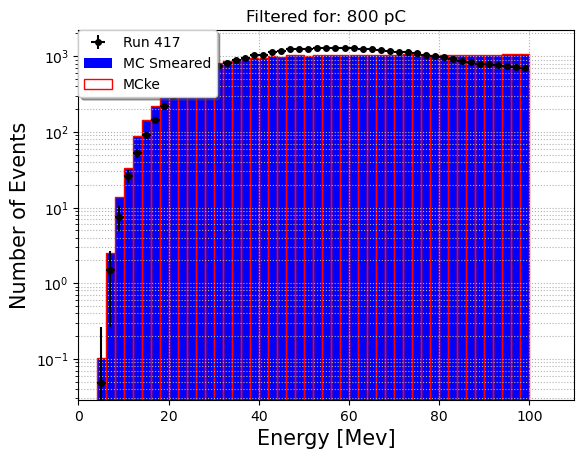

In [46]:
plot_3bar(energy_edge, xlim=[0,np.max(temp_mc_energy)*1.1], bool_errorBar=True,
          countData= densities_sum_Data, data_label=run,
          MC= temp_mc_energy, MC_label="MCke",
          CountMC = mc_densities_sum,mcCount_label='MC Smeared',
          xlabel="Energy [Mev]", title=title
          )

Scaling MC by:  0.10314542805905065
Scaling Count MC by:  0.2062908561180525
Data Integral: 39.23k
MC Smear Integral: 190.15k
MC Energy Integral: 380.30k


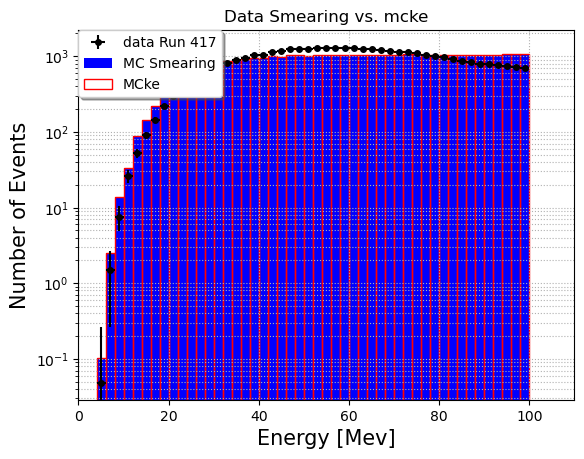

In [47]:
plot_3bar(energy_edge, xlim=[0,np.max(mc_energy[bool_mc])*1.1], bool_errorBar=True,
          countData= densities_sum_Data, data_label="data "+run,
          MC= mc_energy[bool_mc], MC_label="MCke",
          CountMC=mc_densities_sum, mcCount_label="MC Smearing",
          xlabel="Energy [Mev]", title="Data Smearing vs. mcke"
          )

In [14]:
#plot_hist(run417_time,[0,200],0.5,title="deltat",xlabel="Time [uS]",data_label="Run 417")
#plot_hist(run417_time[bool_run417],[0,6],0.5,title="0.5 uS < deltat < 5 uS",xlabel="Time [uS]")
#plot_hist(run417_charge,[0,20000],150,title="digitCharge",xlabel="Total Charge [pC]",data_label="Run 417")
#plot_hist(run417_charge[bool_run417],[0,2000],25,title="0 pC < digitCharge < 1500 pC",xlabel="Total Charge [pC]",data_label="Run 417")

Scaling MC by:  0.2130097474729533


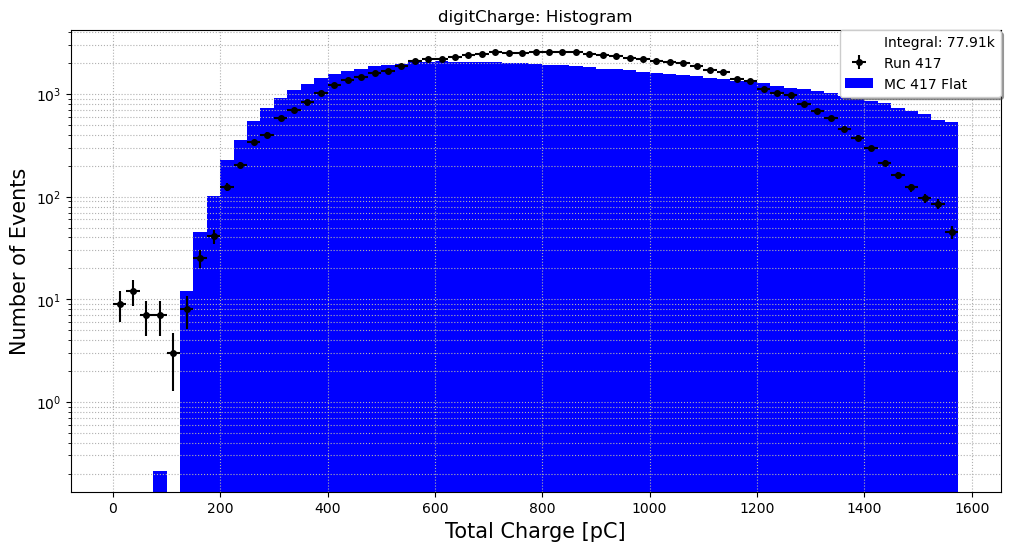

In [48]:
plot_hist(run417_charge[bool_run417],[00,1600],25,title="digitCharge: Histogram",xlabel="Total Charge [pC]",data_label=run,mc_data=flat_mc_charge[bool_mc],mc_label=mc,bool_log=True,bool_error=True)
#plot_hist(run417_charge[bool_run417],[0,2000],50,title="Total Charge: Data vs. MC",xlabel="Total Charge [pC]",data_label="Run 417",mc_data=flat_mc_charge[bool_mc],mc_label="MC 417",bool_log=False,bool_error=True)

Scaling MC by:  0.20655380780335422


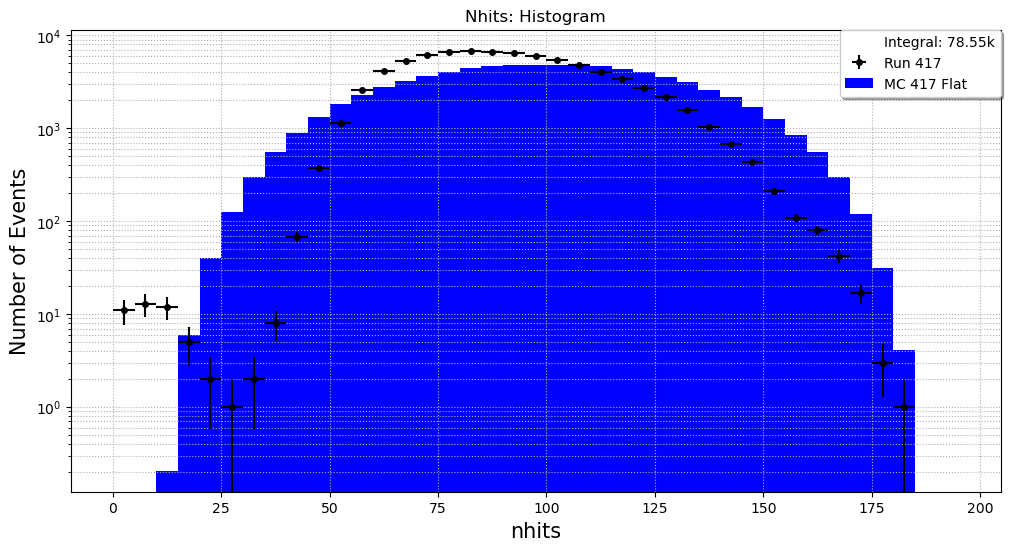

In [49]:
#plot_hist(run417_nhits[bool_run417],[0,200],5,title="Nhits: Data vs. MC",xlabel="nhits",data_label="Run 417",mc_data=mc_nhits[bool_mc],mc_label="MC 417",bool_log=False,bool_error=True)
plot_hist(run417_nhits[bool_run417],[0,200],5,title="Nhits: Histogram",xlabel="nhits",data_label=run,mc_data=mc_nhits[bool_mc],mc_label=mc,bool_log=True,bool_error=True)

In [8]:
sflat_mc_charge = np.array( [i for event in (mc_charge[bool_mc]) for i in event ] )
sflat_mc_pmtID = np.array( [i for event in (mc_pmtID[bool_mc]) for i in event ] )

In [ ]:
sflat_run417_charge = np.array([i for event in (run417_individualcharge[bool_run417]) for i in event ] )
sflat_run417_pmtID = np.array( [i for event in (run417_channel[bool_run417]) for i in event ] )

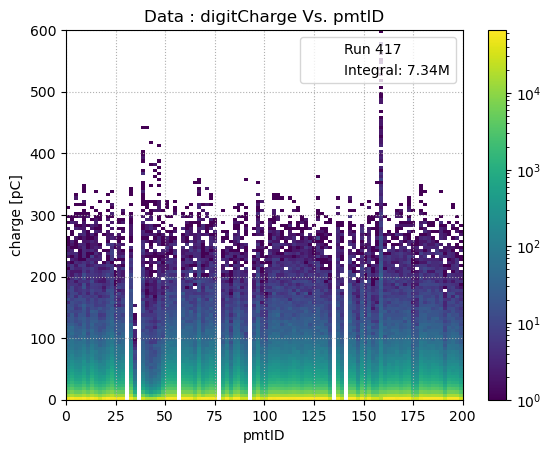

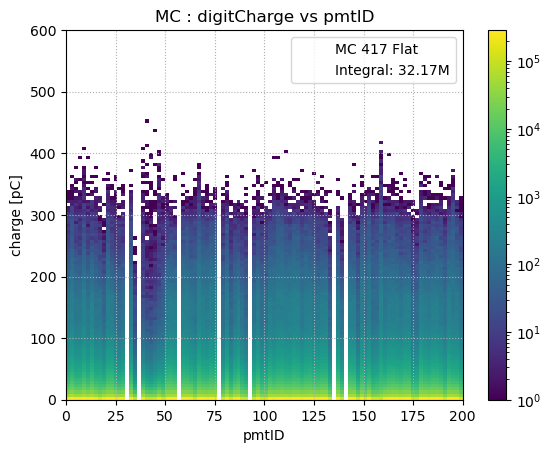

In [85]:
plot_hist2d(datay = sflat_run417_charge, ylabel = "charge [pC]", bin_width_y=5, y_range=[0,600],
            datax = sflat_run417_pmtID, xlabel = "pmtID", bin_width_x= 2, x_range=[0,200],
            title = "Data : digitCharge Vs. pmtID", data_label = run
)
plot_hist2d(datay = sflat_mc_charge, ylabel = "charge [pC]",  bin_width_y=5, y_range=[0,600],
            datax = sflat_mc_pmtID, xlabel = "pmtID", bin_width_x= 2, x_range=[0,200],
            title = "MC : digitCharge vs pmtID", data_label = mc
)

In [54]:
def charge_balance(Qarr):
    """
    =====Charge_balance=====
    Gets the Charge Balance for each event from a given dataset.
    See https://doi.org/10.48550/arXiv.1512.00794 pg. 2 for charge balance definition
    
    param Qarr: A 2d array that contains the individual PMT charge for each event
    return QbArr: 1d array that contains the charge balance for each event 
    
    NOTE The 1/N term is updated per event, it is not clear if this should be static or not.  
    """
    Qarr = np.array(Qarr)
    
    QbArr= []
    for event in Qarr:
        event = np.array(event)
        Qterm = np.sum(event**2)/(np.sum(event)**2)
        Nterm = 1/len(event)
        QbArr.append(np.sqrt(Qterm - Nterm))
    return np.array(QbArr)

mc_charge_balance = np.array(charge_balance(mc_charge[bool_mc]))
run417_charge_balance = np.array( charge_balance(run417_individualcharge[bool_run417]) )


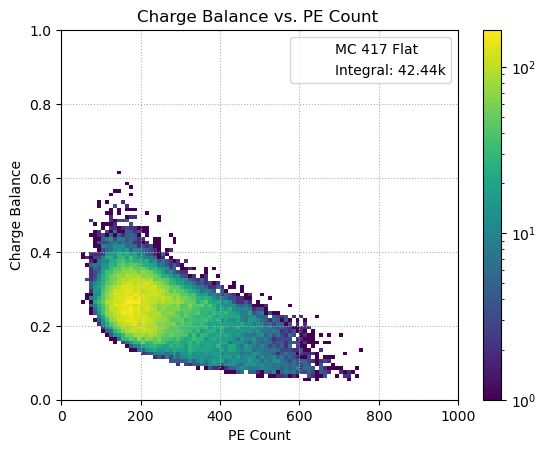

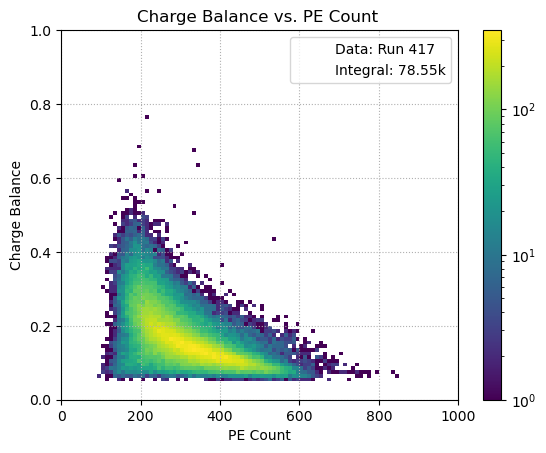

In [56]:
plot_hist2d(datax=mc_peCount[bool_mc], bin_width_x=10, x_range=[0,1000], xlabel="PE Count",
            datay= mc_charge_balance, bin_width_y=0.01, y_range=[0,1],ylabel="Charge Balance",
            title="Charge Balance vs. PE Count ", data_label=mc,
)

plot_hist2d(datax=run417_peCount[bool_run417], bin_width_x=10, x_range=[0,1000], xlabel="PE Count",
            datay= run417_charge_balance, bin_width_y=0.01, y_range=[0,1],ylabel="Charge Balance",
            title="Charge Balance vs. PE Count ", data_label="Data: "+run,
)


Scaling MC by:  0.23591643725332756


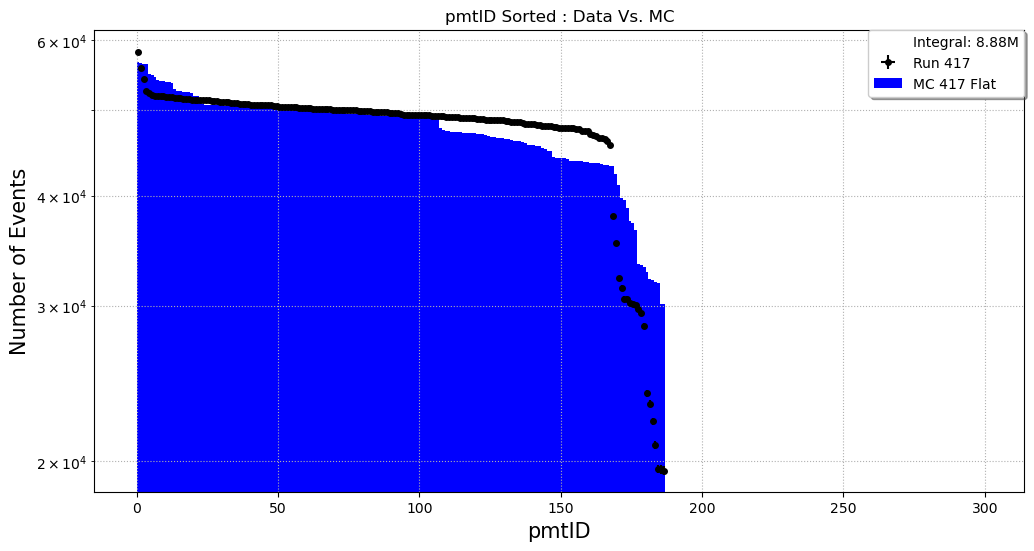

In [53]:
plot_hist(x_range=[0,300],num_bin=1,
          data=(sflat_run417_pmtID), data_label = "Run 417",
          mc_data=( sflat_mc_pmtID ),mc_label = mc,
          xlabel="pmtID", bool_sort = True, bool_error= True, title="pmtID Sorted : Data Vs. MC"
          )

In [12]:
# Create RDataFrame from the events tree of the input file.
mc = "MC 417 Cosmic"
mc_dir = "MC_CosmicSIM_Total300_DIR/"
mc_rdf = get_RDF(path_name="/data/ahicks3/projects/eos/simulations/michelElectron/MC/"+mc_dir)

#All filters and variable definition
#Keeps only events with n number of PMT that triggered on > x amount of charge
mc_rdf = mc_rdf.Define("newdigitCharge","digitCharge * 0.75")
mc_rdf = mc_rdf.Define("nTriggered", "ROOT::VecOps::Sum(newdigitCharge > 15)") # x amount of charge
mc_rdf = mc_rdf.Filter("nTriggered >=5") #n number of PMT

mc_rdf = mc_rdf.Define("new_NHIT", "ROOT::VecOps::Sum( (newdigitCharge > 1.5) && (newdigitCharge < 1600) )")
mc_rdf = mc_rdf.Define("totalCharge","ROOT::VecOps::Sum(newdigitCharge[ newdigitCharge > 1.5 ])") #Calculates total charge for greater then 0 events


Warning in <TFile::Init>: file /data/ahicks3/projects/eos/simulations/michelElectron/MC/MC_CosmicSIM_Total300_DIR/MC_CosmicSIM_Total300_Job220.root probably not closed, trying to recover
Info in <TFile::Recover>: /data/ahicks3/projects/eos/simulations/michelElectron/MC/MC_CosmicSIM_Total300_DIR/MC_CosmicSIM_Total300_Job220.root, recovered key TTree:output at address 61156874
Warning in <TFile::Init>: successfully recovered 1 keys


In [13]:
mc_columns = mc_rdf.AsNumpy(columns=["digitNhits","newdigitCharge","totalCharge","mcke","digitPMTID","mcx","mcy","mcz","mcpdg","timeSinceLastTrigger_us"])

Warning in <TFile::Init>: file /data/ahicks3/projects/eos/simulations/michelElectron/MC/MC_CosmicSIM_Total300_DIR/MC_CosmicSIM_Total300_Job128.root probably not closed, trying to recover
Info in <TFile::Recover>: /data/ahicks3/projects/eos/simulations/michelElectron/MC/MC_CosmicSIM_Total300_DIR/MC_CosmicSIM_Total300_Job128.root, recovered key TTree:output at address 322549317
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file /data/ahicks3/projects/eos/simulations/michelElectron/MC/MC_CosmicSIM_Total300_DIR/MC_CosmicSIM_Total300_Job30.root probably not closed, trying to recover
Info in <TFile::Recover>: /data/ahicks3/projects/eos/simulations/michelElectron/MC/MC_CosmicSIM_Total300_DIR/MC_CosmicSIM_Total300_Job30.root, recovered key TTree:output at address 121781787
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file /data/ahicks3/projects/eos/simulations/michelElectron/MC/MC_CosmicSIM_Total300_DIR/MC_CosmicSIM_Total

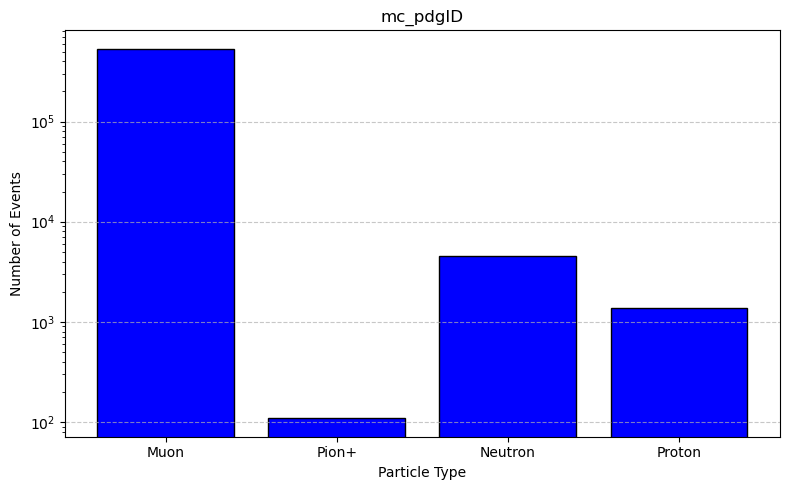

538137


Warning in <TFile::Init>: file /data/ahicks3/projects/eos/simulations/michelElectron/MC/MC_CosmicSIM_Total300_DIR/MC_CosmicSIM_Total300_Job220.root probably not closed, trying to recover
Info in <TFile::Recover>: /data/ahicks3/projects/eos/simulations/michelElectron/MC/MC_CosmicSIM_Total300_DIR/MC_CosmicSIM_Total300_Job220.root, recovered key TTree:output at address 61156874
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file /data/ahicks3/projects/eos/simulations/michelElectron/MC/MC_CosmicSIM_Total300_DIR/MC_CosmicSIM_Total300_Job128.root probably not closed, trying to recover
Info in <TFile::Recover>: /data/ahicks3/projects/eos/simulations/michelElectron/MC/MC_CosmicSIM_Total300_DIR/MC_CosmicSIM_Total300_Job128.root, recovered key TTree:output at address 322549317
Warning in <TFile::Init>: successfully recovered 1 keys
Warning in <TFile::Init>: file /data/ahicks3/projects/eos/simulations/michelElectron/MC/MC_CosmicSIM_Total300_DIR/MC_CosmicSIM_Tota

In [7]:
#Extract mc_branches
mc_nhits = mc_columns["digitNhits"]
mc_pdgID = mc_columns["mcpdg"]
flat_mc_charge = mc_columns["totalCharge"]
mc_charge = mc_columns["newdigitCharge"]
mc_time = mc_rdf.AsNumpy(columns=["timeSinceLastTrigger_us"])["timeSinceLastTrigger_us"]
mc_energy = mc_columns["mcke"]
mc_pmtID = mc_columns["digitPMTID"]
mc_x = mc_columns["mcx"]
mc_y = mc_columns["mcy"]
mc_z = mc_columns["mcz"]

# Plot PDG ID
get_particle_count(abs(mc_pdgID))
print(len(mc_nhits))

In [38]:
#Filter Data based on time and charge
bool_time_mc = get_mask(mc_time, [1, 3])
bool_charge_mc = get_mask(flat_mc_charge,[10,1600])
bool_pdgID_mc = abs(mc_pdgID) == 13
bool_mcCosmic = bool_time_mc & bool_charge_mc & bool_pdgID_mc

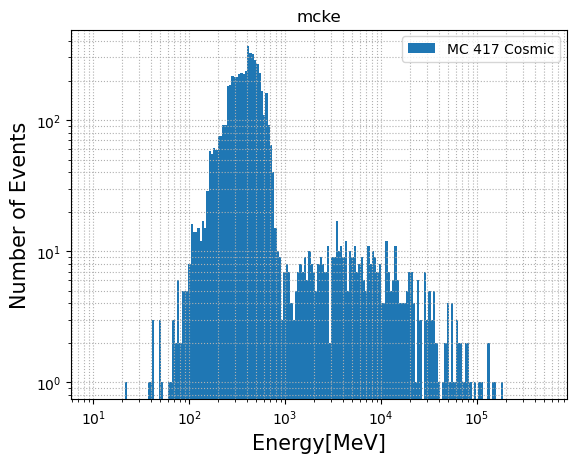

In [39]:
plot_hist(mc_energy[bool_mcCosmic], [1e1,5e5],200, bool_xlog= True,
          xlabel="Energy[MeV]", title="mcke", data_label=mc)

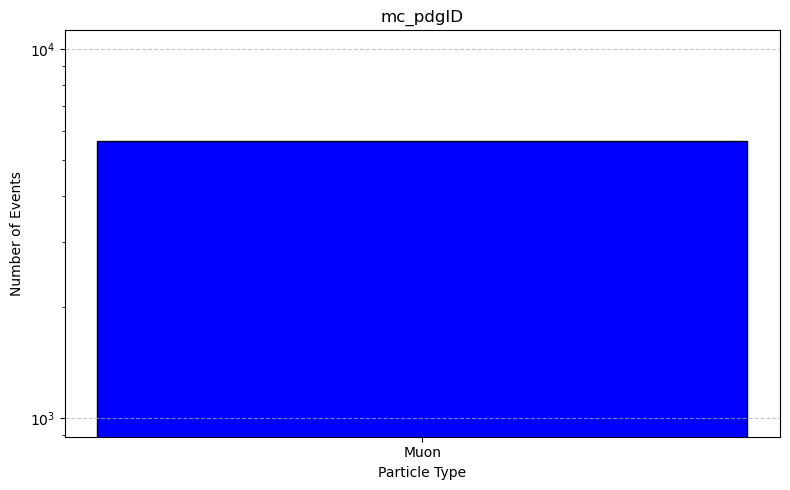

In [40]:
get_particle_count((mc_pdgID[bool_mcCosmic]))